## Import All the Necessary Modules ##
### Auxiliary Imports ###

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

import sklearn.datasets
import sklearn.preprocessing
import sklearn.tree

%matplotlib inline

### FAT Forensics Imports ###

In [2]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.data.augmentation as fatf_augmentation
import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

import fatf

20-Jan-27 13:08:27 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


### Define Bikes dataset location ###

In [3]:
bikes_directory = './partial_train_data/station_1_train.csv'

### Load bikes dataset from 1 CSV ###

In [4]:
numerical_columns = (6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)
feature_names = ['month', 'weekhour', 'isHoliday', 'windMaxSpeed', 'windMeanSpeed', 'windDirection', 'temperature', 'relHumidity'
                  'airPressure', 'precipitation', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes']

bikes_data = np.genfromtxt(
    bikes_directory,
    delimiter=',',
    skip_header=1,
    dtype=np.float32,
    usecols=numerical_columns,
    invalid_raise=True)

bikes_target = np.genfromtxt(
    bikes_directory,
    delimiter=',',
    skip_header=1,
    dtype=int,
    usecols=-1,
    invalid_raise=True)

# Remove any rows with NaNs
nan_rows = np.isnan(bikes_data).any(axis=1)
bikes_data = bikes_data[~nan_rows]
bikes_target = bikes_target[~nan_rows]

print('Number of training data points: %d' %bikes_target.shape[0])

Number of training data points: 16365


### Change target into classification problem ####
We're going to bin the target variable into [0.0<=x<2.0, 2.0<=x<8.0, 8.0<=x<13.0, 13.0<=x<25.0]

<BarContainer object of 3 artists>

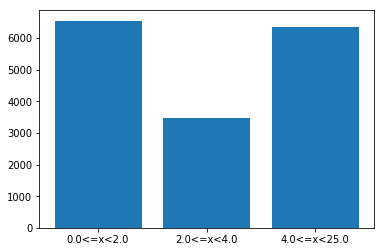

In [5]:
binned_targets = np.digitize(bikes_target, bins=[0.0, 2.0, 4.0, 25.0])
_, counts = np.unique(binned_targets, return_counts=True)
bins = ['0.0<=x<2.0', '2.0<=x<4.0', '4.0<=x<25.0']
plt.bar(bins, counts)

In [6]:
clf_bikes = RandomForestClassifier(n_estimators=100)
clf_bikes.fit(bikes_data, binned_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
bikes_training_predictions = clf_bikes.predict(bikes_data)

bikes_training_accuracy = sklearn.metrics.accuracy_score(
    bikes_target, bikes_training_predictions)

print('Training set *accuracy*: {:.3}.'.format(bikes_training_accuracy))

Training set *accuracy*: 0.306.


# Using your own model #
In order to use your own model, in the next cell you can load in your trained model, the data used and feature names corresponding to the columns in the data. 
In order to simplify the process of generating explanations, it would be best to use a classifcation model that predicts the number of bikes, given that the target variable is split into bins.

The model must be able to output prediction probabilities via a `predict_proba` method.

The data must be in a numpy ndarray format in order to use the sklearn local models.

Please ensure that the feature names are the same length as the number of columns in the data array.

In [ ]:
# Define the model to predict bins
clf_bikes = clf_bikes

# Define data in the form of numpy array
bikes_data = bikes_data

# Define list of feature names corresponding to the columns in the data loaded in
feature_names = feature_names

### Select Data Point for Explanation ###

In [8]:
data_point = bikes_data[0]
data_point_target = binned_targets[0]

### Build Surrogates ###

In [9]:
local_samples_number = 1000

sampler = fatf_augmentation.NormalSampling(bikes_data)

sampled_data = sampler.sample(data_point, samples_number=local_samples_number)

sampled_data_prediction = clf_bikes.predict_proba(sampled_data)[:, data_point_target]

distance_normal = fatf_distances.euclidean_point_distance(data_point, sampled_data)

# Kernel width is set to the default value in the LIME implementation
kernel_width = 0.75 * np.sqrt(sampled_data.shape[1])
sampled_weights = fatf_kernels.exponential_kernel(distance_normal, width=kernel_width)

#### Linear Model (Ridge Regression) ####

In [10]:
ridge = Ridge(alpha=1, fit_intercept=True)
ridge.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [21]:
for feature, coef in zip(feature_names, ridge.coef_.tolist()):
    print(feature + ': {:.2e}'.format(coef))

month: 3.03e-08
weekhour: -1.39e-10
isHoliday: 1.08e-10
windMaxSpeed: 2.93e-08
windMeanSpeed: 1.69e-08
windDirection: -2.74e-08
temperature: -2.18e-08
relHumidityairPressure: -3.58e-09
precipitation: -1.76e-08
bikes_3h_ago: -5.19e-10
full_profile_3h_diff_bikes: -2.47e-08
full_profile_bikes: 5.42e-09


#### Linear Model with Discretised Features ####

In [12]:
# finish code here

#### Surrogate Decision Tree ####

In [13]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

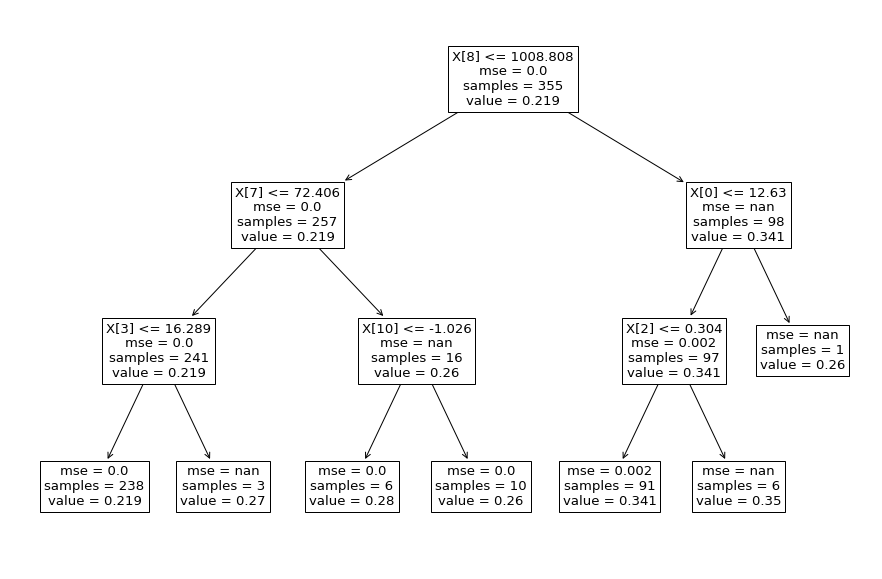

In [14]:
plt.figure(figsize=(15, 10))
tree_text = sklearn.tree.plot_tree(tree) #feature_names=feature_names)